In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from scipy import interpolate
from statsmodels.formula.api import logit
from sklearn.linear_model import LinearRegression, LogisticRegression

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import features

folder = f'..\\Traffic, Investigations _ Other\\' 

stations = pd.read_csv(folder + 'police_stations.csv', delimiter=',')
print(len(stations))
stations.head()


c:\Users\anujs\Anaconda3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


22


,DISTRICT_NUMBER,LOCATION,lat,lng,fips
0,7,Bustleton Ave & Bowler St,40.091030,-75.032680,4.210100e+11
1,14,Haines St & Germantown Ave,40.038425,-75.176942,4.210100e+11
2,8,Academy Rd & Red Lion Rd,40.081760,-74.994452,4.210200e+11
3,2,Harbison Ave & Levick St,40.031562,-75.063272,4.210100e+11
4,35,N Broad St & Champlost St,40.044428,-75.143506,4.210100e+11


In [2]:
population = pd.read_csv(folder + 'philadelphia_population_metrics.csv', delimiter=',')
print(len(population))
population.head()

384


,OBJECTID,GEOGRAPHY_NAME,GEOGRAPHY,COUNT_ALL_RACES_ETHNICITIES,COUNT_WHITE_NH,COUNT_BLACK_NH,COUNT_ASIAN_NH,COUNT_HISPANIC,PERCENT_WHITE_NH,PERCENT_BLACK_NH,PERCENT_ASIAN_NH,PERCENT_HISPANIC,Shape__Area,Shape__Length
0,1,42101000100,Census tract,3478,2890,207,173,126,83.093732,5.951696,4.974123,3.622772,1.202257e+06,4528.078584
1,2,42101000200,Census tract,2937,665,284,1855,79,22.642152,9.669731,63.159687,2.689820,6.516548e+05,3688.958965
2,3,42101000300,Census tract,3169,2290,324,328,135,72.262543,10.224045,10.350268,4.260019,9.319655e+05,5040.148986
3,4,42101000401,Census tract,2125,1049,376,519,107,49.364706,17.694118,24.423529,5.035294,3.978075e+05,2733.448537
4,5,42101000402,Census tract,3142,2455,173,356,109,78.134946,5.506047,11.330363,3.469128,5.174244e+05,3547.054900


In [3]:
crimes = pd.read_csv(folder + 'crimes.csv', delimiter=',')
# drop na
crimes.dropna(subset=['lat', 'lng'],inplace=True)
crimes['year'] = crimes['dispatch_date'].apply(lambda x: x.split('-')[0])
print(len(crimes))
print(crimes.head())
crimes.value_counts('text_general_code')
crimes.value_counts('psa')

1573526
   objectid psa      dispatch_date_time dispatch_date dispatch_time  \
0    218891   2  2022-09-08 19:21:00+00    2022-09-08      15:21:00   
1    218892   2  2022-09-14 21:41:00+00    2022-09-14      17:41:00   
2    218893   2  2022-09-19 19:23:00+00    2022-09-19      15:23:00   
3    218894   2  2022-08-22 13:38:00+00    2022-08-22      09:38:00   
4    218895   2  2022-08-20 14:31:00+00    2022-08-20      10:31:00   

          location_block   text_general_code        lat        lng  \
0  3200 BLOCK N BROAD ST              Thefts  40.002741 -75.153068   
1  3200 BLOCK N BROAD ST              Thefts  40.002741 -75.153068   
2  3200 BLOCK N BROAD ST              Thefts  40.002741 -75.153068   
3        0 BLOCK WOLF ST  Theft from Vehicle  39.918351 -75.145999   
4        0 BLOCK WOLF ST  Theft from Vehicle  39.918351 -75.145999   

           fips  year  
0  4.210102e+11  2022  
1  4.210102e+11  2022  
2  4.210102e+11  2022  
3  4.210198e+11  2022  
4  4.210198e+11  2022  


psa
2      525449
1      456631
3      418808
4       71242
2.0     35877
1.0     29746
3.0     27473
4.0      5167
A        2530
R           1
S           1
dtype: int64

In [7]:
investigations = pd.read_csv(folder + 'investigations.csv', delimiter=',')
investigations['year'] = pd.DatetimeIndex(investigations['datetimeoccur']).year.astype(str)
print(len(investigations))
print(investigations.columns)
print(investigations.value_counts('individual_arrested'))

2785087
Index(['id', 'datetimeoccur', 'weekday', 'location', 'districtoccur', 'psa',
       'stoptype', 'inside_or_outside', 'gender', 'race', 'age',
       'individual_frisked', 'individual_searched', 'individual_arrested',
       'individual_contraband', 'vehicle_frisked', 'vehicle_searched',
       'vehicle_contraband', 'lat', 'lng', 'fips', 'year'],
      dtype='object')


,id,datetimeoccur,weekday,location,districtoccur,psa,stoptype,inside_or_outside,gender,race,...,individual_searched,individual_arrested,individual_contraband,vehicle_frisked,vehicle_searched,vehicle_contraband,lat,lng,fips,year
0,1767776,2014-05-14 00:00:00+00,TUESDAY,300 BLOCK S 13TH ST,6,3,pedestrian,Outside,Male,Black - Non-Latino,...,0,0,0,0,0,0,39.946671,-75.162656,4.210100e+11,2014
1,1767787,2014-05-14 00:00:00+00,TUESDAY,300 BLOCK S 13TH ST,6,3,pedestrian,Outside,Male,Black - Latino,...,0,0,0,0,0,0,39.946671,-75.162656,4.210100e+11,2014
2,2305431,2014-09-26 13:10:00+00,FRIDAY,300 BLOCK S 13TH ST,6,3,pedestrian,Outside,Male,Black - Non-Latino,...,0,0,0,0,0,0,39.946671,-75.162656,4.210100e+11,2014
3,1739213,2014-02-26 15:00:00+00,WEDNESDAY,2ND AND SPRING GARDEN ST,6,1,vehicle,Outside,Male,Black - Non-Latino,...,0,0,0,0,0,0,39.960704,-75.141439,4.210104e+11,2014
4,2246508,2014-08-29 19:55:00+00,FRIDAY,2nd and SPRING GARDEN,6,1,vehicle,Outside,Male,White - Non-Latino,...,0,0,0,0,0,0,39.960704,-75.141439,4.210104e+11,2014


In [8]:
stops = pd.read_csv(folder + 'traffic_stops_philadelphia.csv', delimiter=',')
stops['year'] = stops['date'].apply(lambda x: x.split('-')[0])
stops.dropna(subset=['lat', 'lng'], inplace=True)
print(len(stops))
print(stops.columns)
print(stops.value_counts('arrest_made'))



<ipython-input-8-6e2c1ae53bef>:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  stops = pd.read_csv(folder + 'traffic_stops_philadelphia.csv', delimiter=',')


1760399
Index(['objectid', 'date', 'time', 'location', 'lat', 'lng', 'district',
       'service_area', 'subject_age', 'subject_race', 'subject_sex', 'type',
       'arrest_made', 'outcome', 'contraband_found', 'frisk_performed',
       'search_conducted', 'search_person', 'search_vehicle', 'raw_race',
       'raw_individual_contraband', 'raw_vehicle_contraband', 'fips', 'year'],
      dtype='object')
arrest_made
False    1669984
True       90415
dtype: int64


In [9]:
lat_min, lng_min, lat_window, lng_window = features.get_coord_mask_params(crimes)
coord_mask = features.get_coord_mask(stops, lat_min, lng_min, lat_window, lng_window)
print(len(coord_mask.drop_duplicates(['mean_lat', 'mean_lng'])))
stops_agg = pd.merge(stops, coord_mask, on=['lat', 'lng'])
stops_agg = stops_agg.groupby(['year', 'mean_lat', 'mean_lng']).agg({'objectid': 'count', 'arrest_made': 'sum', }).reset_index().rename(columns={'objectid': 'stops', 'arrest_made': 'stop_arrests',  })
stops_agg['dist_to_station'] = stops_agg.apply(lambda x: features.get_closest_station((x['mean_lat'], x['mean_lng']))[0], axis=1)
stops_agg['closest_station'] = stops_agg.apply(lambda x: features.get_closest_station((x['mean_lat'], x['mean_lng']))[1], axis=1)
stops_agg.head()


443


,year,mean_lat,mean_lng,stops,stop_arrests,dist_to_station,closest_station
0,2014,39.875021,-75.257552,25,0,0.055632,65th St & Woodland Ave
1,2014,39.875021,-75.236122,193,6,0.050585,65th St & Woodland Ave
2,2014,39.875021,-75.225407,11,0,0.051334,65th St & Woodland Ave
3,2014,39.883777,-75.257552,77,2,0.047815,65th St & Woodland Ave
4,2014,39.883777,-75.246837,84,1,0.043628,65th St & Woodland Ave


In [10]:
# read demographics_data csv
demographics = pd.read_csv('demographics_data.csv', delimiter=',')
demographics = demographics[['ZillowName', 'geometry', 'lat', 'lng',
                            'COUNT_ALL_RACES_ETHNICITIES', 'PERCENT_WHITE_NH',
                            'PERCENT_BLACK_NH', 'PERCENT_ASIAN_NH', 'PERCENT_HISPANIC',]]
demographics.dropna(subset=['lat', 'lng'], inplace=True)
demographics.dropna(subset=['PERCENT_WHITE_NH'], inplace=True)
print(len(demographics))
demographics.head()

140


,ZillowName,geometry,lat,lng,COUNT_ALL_RACES_ETHNICITIES,PERCENT_WHITE_NH,PERCENT_BLACK_NH,PERCENT_ASIAN_NH,PERCENT_HISPANIC
0,Academy Gardens,POLYGON ((-74.99850760499999 40.06434635800008...,40.062077,-75.004360,4390.0,84.533030,6.332574,2.665148,5.239180
2,Allegheny West,POLYGON ((-75.16592149899998 40.00327234900004...,40.002277,-75.173855,3562.5,5.029019,90.096344,0.599401,2.862027
3,Andorra,POLYGON ((-75.22462652999997 40.06686047600004...,40.066465,-75.237457,2437.0,85.350841,7.180960,3.816167,2.215839
4,Aston Woodbridge,POLYGON ((-75.00859651999997 40.05368637200007...,40.065084,-75.014359,5373.0,64.228550,21.868602,2.493951,8.766052
5,Bartram Village,POLYGON ((-75.20732671899998 39.93349938500006...,39.931543,-75.217097,2539.0,2.205593,93.658921,0.078771,2.166207


In [11]:
# find closest lat long from demographic df for each row in stops_agg and add it as a column
# stops_agg['closest_lat'] = stops_agg.apply(lambda x: features.find_closest((x['mean_lat'], x['mean_lng']))[2], axis=1)

def get_closest_demog(lat, lng, df):
    closest = df.iloc[(df[['lat', 'lng']] - [lat, lng]).pow(2).sum(1).argsort()[:1]]
    return closest

get_closest_demog(stops_agg['mean_lat'][0], stops_agg['mean_lng'][0], demographics)
# loop over stops_agg and create new df with closest demographics
closest_demogs = pd.DataFrame()
for i in range(len(stops_agg)):
    closest_demog = get_closest_demog(stops_agg['mean_lat'][i], stops_agg['mean_lng'][i], demographics)
    closest_demog.drop(columns=['lat','lng'], inplace=True)
    closest_demogs = closest_demogs.append(closest_demog)

closest_demogs.reset_index(drop=True, inplace=True)    
# horizontally stack the two dataframes
stops_agg = pd.concat([stops_agg, closest_demogs], axis=1)
stops_agg.head()
#stops_agg['dist_to_station'] = stops_agg.apply(lambda x: features.get_closest_station((x['mean_lat'], x['mean_lng']))[0], axis=1)

<ipython-input-11-30e816010adb>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  closest_demog.drop(columns=['lat','lng'], inplace=True)
<ipython-input-11-30e816010adb>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  closest_demog.drop(columns=['lat','lng'], inplace=True)
<ipython-input-11-30e816010adb>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  closest_demog.drop(columns=['lat','lng'], inplace=True)
<ipython-input-11-30e8160

,year,mean_lat,mean_lng,stops,stop_arrests,dist_to_station,closest_station,ZillowName,geometry,COUNT_ALL_RACES_ETHNICITIES,PERCENT_WHITE_NH,PERCENT_BLACK_NH,PERCENT_ASIAN_NH,PERCENT_HISPANIC
0,2014,39.875021,-75.257552,25,0,0.055632,65th St & Woodland Ave,Eastwick,POLYGON ((-75.22786497999994 39.90731456100008...,818.333333,16.609108,73.224523,3.081975,4.245324
1,2014,39.875021,-75.236122,193,6,0.050585,65th St & Woodland Ave,Eastwick,POLYGON ((-75.22786497999994 39.90731456100008...,818.333333,16.609108,73.224523,3.081975,4.245324
2,2014,39.875021,-75.225407,11,0,0.051334,65th St & Woodland Ave,Eastwick,POLYGON ((-75.22786497999994 39.90731456100008...,818.333333,16.609108,73.224523,3.081975,4.245324
3,2014,39.883777,-75.257552,77,2,0.047815,65th St & Woodland Ave,Eastwick,POLYGON ((-75.22786497999994 39.90731456100008...,818.333333,16.609108,73.224523,3.081975,4.245324
4,2014,39.883777,-75.246837,84,1,0.043628,65th St & Woodland Ave,Eastwick,POLYGON ((-75.22786497999994 39.90731456100008...,818.333333,16.609108,73.224523,3.081975,4.245324


In [12]:
# filter out outlier latitudes
investigations=investigations[investigations['lat']>= lat_min]
coord_mask = features.get_coord_mask(investigations, lat_min, lng_min, lat_window, lng_window)

investigations_masked = pd.merge(investigations, coord_mask, on=['lat', 'lng'])
investigations_agg = investigations_masked.groupby(['year', 'mean_lat', 'mean_lng']).agg({'id': 'count', 'individual_arrested': 'sum', }).reset_index().rename(columns={'id': 'investigations', 'individual_arrested': 'investigation_arrests',  })
investigations_agg.head()

,year,mean_lat,mean_lng,investigations,investigation_arrests
0,2014,39.875021,-75.268267,1,0
1,2014,39.875021,-75.246837,1,0
2,2014,39.875021,-75.236122,6,1
3,2014,39.875021,-75.214692,1,0
4,2014,39.883777,-75.257552,62,3


In [13]:
agg_features = pd.merge(stops_agg, investigations_agg, on=['year', 'mean_lat', 'mean_lng'], how='inner')
print(len(agg_features))
agg_features.head()

#investigations_agg.head()

2092


,year,mean_lat,mean_lng,stops,stop_arrests,dist_to_station,closest_station,ZillowName,geometry,COUNT_ALL_RACES_ETHNICITIES,PERCENT_WHITE_NH,PERCENT_BLACK_NH,PERCENT_ASIAN_NH,PERCENT_HISPANIC,investigations,investigation_arrests
0,2014,39.875021,-75.236122,193,6,0.050585,65th St & Woodland Ave,Eastwick,POLYGON ((-75.22786497999994 39.90731456100008...,818.333333,16.609108,73.224523,3.081975,4.245324,6,1
1,2014,39.883777,-75.257552,77,2,0.047815,65th St & Woodland Ave,Eastwick,POLYGON ((-75.22786497999994 39.90731456100008...,818.333333,16.609108,73.224523,3.081975,4.245324,62,3
2,2014,39.883777,-75.246837,84,1,0.043628,65th St & Woodland Ave,Eastwick,POLYGON ((-75.22786497999994 39.90731456100008...,818.333333,16.609108,73.224523,3.081975,4.245324,67,1
3,2014,39.883777,-75.236122,298,4,0.041835,65th St & Woodland Ave,Eastwick,POLYGON ((-75.22786497999994 39.90731456100008...,818.333333,16.609108,73.224523,3.081975,4.245324,81,0
4,2014,39.883777,-75.225407,34,0,0.042738,65th St & Woodland Ave,Eastwick,POLYGON ((-75.22786497999994 39.90731456100008...,818.333333,16.609108,73.224523,3.081975,4.245324,3,0


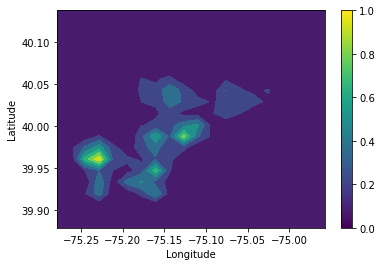

<ipython-input-39-da5a8df90e5b>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  agg_features_year['crime_score'] = agg_features.apply(lambda x: f(x['mean_lng'], x['mean_lat'])[0], axis=1)


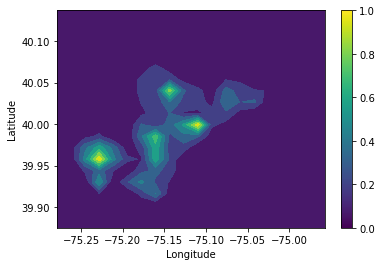

<ipython-input-39-da5a8df90e5b>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  agg_features_year['crime_score'] = agg_features.apply(lambda x: f(x['mean_lng'], x['mean_lat'])[0], axis=1)


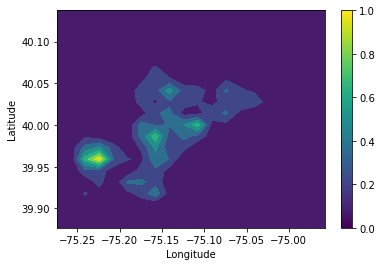

<ipython-input-39-da5a8df90e5b>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  agg_features_year['crime_score'] = agg_features.apply(lambda x: f(x['mean_lng'], x['mean_lat'])[0], axis=1)


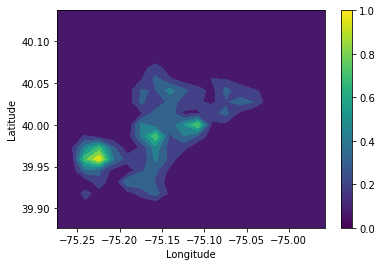

<ipython-input-39-da5a8df90e5b>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  agg_features_year['crime_score'] = agg_features.apply(lambda x: f(x['mean_lng'], x['mean_lat'])[0], axis=1)


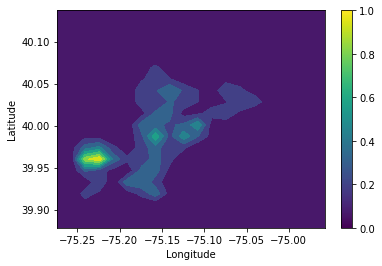

<ipython-input-39-da5a8df90e5b>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  agg_features_year['crime_score'] = agg_features.apply(lambda x: f(x['mean_lng'], x['mean_lat'])[0], axis=1)


In [39]:
max_densities =[]
for year in range(2014,2019):
    year = str(year)
    crimes_year = crimes[crimes["year"]==year]
    xy_crime = (crimes_year[["lng","lat"]].dropna()).to_numpy()
    if len(crimes_year) == 0:
        print(f'No crime data for {year}')
        continue
    xx,yy,density = estimate_density(xy_crime) #2D numpy array
    max_densities.append(np.max(density))
    f = interpolate.interp2d(xx[:,0], yy[0,:], density, kind='linear')
    agg_features_year = agg_features[agg_features['year']==year]
    agg_features_year['crime_score'] = agg_features.apply(lambda x: f(x['mean_lng'], x['mean_lat'])[0], axis=1)
    agg_features_year.to_csv(f'agg_features_{year}.csv', index=False)

In [42]:

max_density = max(max_densities)
if agg_features['crime_score'].max() > 1:
    agg_features['crime_score'] = agg_features['crime_score']/max_density

In [63]:
crimes.groupby('year').count()

,objectid,psa,dispatch_date_time,dispatch_date,dispatch_time,location_block,text_general_code,lat,lng,fips
year,,,,,,,,,,
2012,72,72,72,72,72,72,72,72,72,72
2013,176541,176517,176541,176541,176541,176540,176541,176541,176541,176541
2014,176195,176135,176195,176195,176195,176195,176195,176195,176195,176195
2015,174714,174680,174714,174714,174714,174713,174714,174714,174714,174714
2016,159598,159555,159598,159598,159598,159598,159598,159598,159598,159598
2017,157290,157224,157290,157290,157290,157289,157290,157290,157290,157290
2018,152665,152553,152665,152665,152665,152664,152665,152665,152665,152665
2019,159680,159654,159680,159680,159680,159680,159680,159680,159680,159680
2020,133023,132982,133023,133023,133023,133022,133023,133023,133023,133023


In [77]:
agg_features_hisp_low = agg_features[agg_features['PERCENT_HISPANIC']<10]
agg_features_hisp_high = agg_features[agg_features['PERCENT_HISPANIC']>30]

print(agg_features.columns)
x_cols = ['stops', 'stop_arrests',
       'dist_to_station', 
       'PERCENT_WHITE_NH', 'PERCENT_BLACK_NH',
       'PERCENT_ASIAN_NH', 'PERCENT_HISPANIC', 
       'investigations', 'investigation_arrests']

from sklearn.preprocessing import MinMaxScaler 
scaler = MinMaxScaler()
agg_features_scaled = agg_features_hisp_high.copy()
agg_features_scaled[x_cols] = scaler.fit_transform(agg_features_scaled[x_cols])

logistic_reg = logit( f"crime_score ~ {' + '.join(x_cols)}", agg_features_scaled).fit()
logistic_reg.summary2()

# regressor1 = LinearRegression()
# regressor1.fit(agg_features_scaled[x_cols], agg_features_scaled['crime_score'])
# print(pd.DataFrame(np.array([x_cols+['Intercept'], np.append(regressor1.coef_,regressor1.intercept_)]).T ))
# # r square of regressor1
# regressor1.score(agg_features_scaled[x_cols], agg_features_scaled['crime_score'])
# # get t values of regressor1
# from scipy import stats


Index(['year', 'mean_lat', 'mean_lng', 'stops', 'stop_arrests',
       'dist_to_station', 'closest_station', 'ZillowName', 'geometry',
       'COUNT_ALL_RACES_ETHNICITIES', 'PERCENT_WHITE_NH', 'PERCENT_BLACK_NH',
       'PERCENT_ASIAN_NH', 'PERCENT_HISPANIC', 'investigations',
       'investigation_arrests', 'crime_score'],
      dtype='object')
Optimization terminated successfully.
         Current function value: 0.374882
         Iterations 7


<class 'statsmodels.iolib.summary2.Summary'>
"""
                            Results: Logit
=======================================================================
Model:                  Logit              Pseudo R-squared:   -9.921  
Dependent Variable:     crime_score        AIC:                141.4617
Date:                   2023-03-11 15:10   BIC:                172.3377
No. Observations:       162                Log-Likelihood:     -60.731 
Df Model:               9                  LL-Null:            -5.5612 
Df Residuals:           152                LLR p-value:        1.0000  
Converged:              1.0000             Scale:              1.0000  
No. Iterations:         7.0000                                         
-----------------------------------------------------------------------
                       Coef.   Std.Err.    z    P>|z|   [0.025   0.975]
-----------------------------------------------------------------------
Intercept              16.4048  23.3325  0.7031 0.4820 -29.3260 62.1357
stops                  -4.6497  13.3303 -0.3488 0.7272 -30.7766 21.4772
stop_arrests            7.0010  20.2044  0.3465 0.7290 -32.5989 46.6010
dist_to_station        -1.1874   1.4174 -0.8377 0.4022  -3.9653  1.5906
PERCENT_WHITE_NH      -17.4408  23.3356 -0.7474 0.4548 -63.1776 28.2960
PERCENT_BLACK_NH      -14.4187  20.8633 -0.6911 0.4895 -55.3100 26.4725
PERCENT_ASIAN_NH       -5.1208   5.6312 -0.9094 0.3632 -16.1577  5.9161
PERCENT_HISPANIC      -16.9072  23.2739 -0.7264 0.4676 -62.5233 28.7089
investigations          5.8979  12.8344  0.4595 0.6459 -19.2571 31.0529
investigation_arrests  -7.2836  20.2216 -0.3602 0.7187 -46.9173 32.3501
=======================================================================

"""

In [73]:
logistic_reg.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                             Results: Logit
========================================================================
Model:                 Logit               Pseudo R-squared:    -3.297  
Dependent Variable:    crime_score         AIC:                 458.7305
Date:                  2023-03-11 15:04    BIC:                 512.6816
No. Observations:      1628                Log-Likelihood:      -219.37 
Df Model:              9                   LL-Null:             -51.049 
Df Residuals:          1618                LLR p-value:         1.0000  
Converged:             1.0000              Scale:               1.0000  
No. Iterations:        8.0000                                           
------------------------------------------------------------------------
                       Coef.   Std.Err.    z    P>|z|   [0.025   0.975] 
------------------------------------------------------------------------
Intercept             -47.5319  15.2429 -3.1183 0.0018 -77.4075 -17.6563
stops                   3.6353   4.0650  0.8943 0.3712  -4.3320  11.6026
stop_arrests           -2.5385   4.5370 -0.5595 0.5758 -11.4308   6.3539
dist_to_station        -2.0065   0.5725 -3.5048 0.0005  -3.1285  -0.8844
PERCENT_WHITE_NH       45.8181  15.3857  2.9780 0.0029  15.6627  75.9736
PERCENT_BLACK_NH       44.6410  14.9652  2.9830 0.0029  15.3096  73.9723
PERCENT_ASIAN_NH       17.7553   5.5112  3.2217 0.0013   6.9536  28.5571
PERCENT_HISPANIC        5.0910   1.7855  2.8513 0.0044   1.5915   8.5905
investigations         -3.0141   3.6505 -0.8257 0.4090 -10.1689   4.1407
investigation_arrests   3.2081   4.1553  0.7720 0.4401  -4.9362  11.3523
========================================================================

"""

## Density

In [ ]:
def estimate_density(xy_crimes_,visualize=True,sigma_=0.05):

    """

    xy_crimes : (n,2) numpy array containing x,y coordinates of crimes

    for the selected period

    """

    x = xy_crimes_[:,0]

    y = xy_crimes_[:,1]

    xy__ = np.vstack([x, y])

    kde = gaussian_kde(xy__,bw_method=sigma_)

    xmin, xmax = x.min(), x.max()

    ymin, ymax = y.min(), y.max()

    xx, yy = np.mgrid[xmin:xmax:20j, ymin:ymax:20j]

    positions = np.vstack([xx.ravel(), yy.ravel()])

 

    density = np.reshape(kde(positions).T, xx.shape)

   

    if visualize:
        fig, ax = plt.subplots()
        ax.contourf(xx, yy, density)
        plt.xlabel("Longitude")
        plt.ylabel("Latitude")
        fig.colorbar(ax.collections[0])
        plt.show()

    return xx,yy,density